<a href="https://colab.research.google.com/github/KalpShah1384/Zidio-Team-4/blob/main/FINAL_TSA_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = yf.download('TSLA',start = '2019-06-15', end = '2025-06-15')

[*********************100%***********************]  1 of 1 completed


In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
#from datetime import datetime

#Read the csv file
print(df.head())

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2019-06-17  15.002000  15.133333  14.284667  14.365333  184752000
2019-06-18  14.982667  15.649333  14.837333  15.248000  190737000
2019-06-19  15.095333  15.184667  14.737333  15.007333   98626500
2019-06-20  14.641333  15.126667  14.423333  14.866667  177952500
2019-06-21  14.790667  14.812000  14.366667  14.414667  123031500


In [3]:
#Separate dates for future plotting
df = df.reset_index() # Reset the index to make 'Date' a column
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates.

1493   2025-05-23
1494   2025-05-27
1495   2025-05-28
1496   2025-05-29
1497   2025-05-30
1498   2025-06-02
1499   2025-06-03
1500   2025-06-04
1501   2025-06-05
1502   2025-06-06
1503   2025-06-09
1504   2025-06-10
1505   2025-06-11
1506   2025-06-12
1507   2025-06-13
Name: Date, dtype: datetime64[ns]


In [4]:
print(df.head())

Price        Date      Close       High        Low       Open     Volume
Ticker                  TSLA       TSLA       TSLA       TSLA       TSLA
0      2019-06-17  15.002000  15.133333  14.284667  14.365333  184752000
1      2019-06-18  14.982667  15.649333  14.837333  15.248000  190737000
2      2019-06-19  15.095333  15.184667  14.737333  15.007333   98626500
3      2019-06-20  14.641333  15.126667  14.423333  14.866667  177952500
4      2019-06-21  14.790667  14.812000  14.366667  14.414667  123031500


In [5]:
df = df.set_index('Date')
print(df.head())

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2019-06-17  15.002000  15.133333  14.284667  14.365333  184752000
2019-06-18  14.982667  15.649333  14.837333  15.248000  190737000
2019-06-19  15.095333  15.184667  14.737333  15.007333   98626500
2019-06-20  14.641333  15.126667  14.423333  14.866667  177952500
2019-06-21  14.790667  14.812000  14.366667  14.414667  123031500


In [6]:
#Variables for training
# cols = list(df)[0]
cols = 'Close'
#Date columns is not used in training.
print(cols)

Close


<Axes: xlabel='Date'>

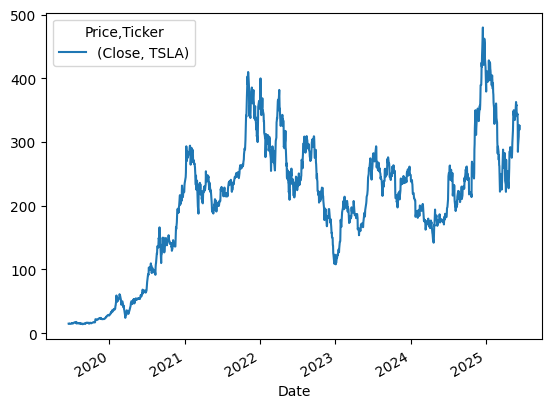

In [7]:
#New dataframe with only training data - 5 columns
df_for_training = df[[cols]].astype(float)

df_for_training.plot.line()

In [8]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
# scaler = scaler.fit(df_for_training)
# df_for_training_scaled = scaler.transform(df_for_training)

df_for_training_scaled = scaler.fit_transform(df_for_training)

In [9]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 1. We will make timesteps = 15 (past days data used for training).

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 15  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1493, 15, 1).
trainY shape == (1493, 1).


In [10]:
# Split data into train and test sets (80-20 split)
split_index = int(0.8 * len(trainX))
X_train, X_test = trainX[:split_index], trainX[split_index:]
y_train, y_test = trainY[:split_index], trainY[split_index:]

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 1194
Test set size: 299


In [11]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
model.summary()


# fit the model
# history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6412 - mae: 0.5693 - mse: 0.6412 - val_loss: 0.0176 - val_mae: 0.1088 - val_mse: 0.0176
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0882 - mae: 0.2176 - mse: 0.0882 - val_loss: 0.0215 - val_mae: 0.1138 - val_mse: 0.0215
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0808 - mae: 0.2075 - mse: 0.0808 - val_loss: 0.0133 - val_mae: 0.0888 - val_mse: 0.0133
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0580 - mae: 0.1829 - mse: 0.0580 - val_loss: 0.0171 - val_mae: 0.0991 - val_mse: 0.0171
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0559 - mae: 0.1713 - mse: 0.0559 - val_loss: 0.0109 - val_mae: 0.0823 - val_mse: 0.0109
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0489 - mae: 0.1668 - mse: 0.0489 - val_loss: 0.0123 - val_mae: 0.0849 - val_mse: 0.0123
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0545 - mae: 0.1726 - mse: 0.0545 - val_loss:

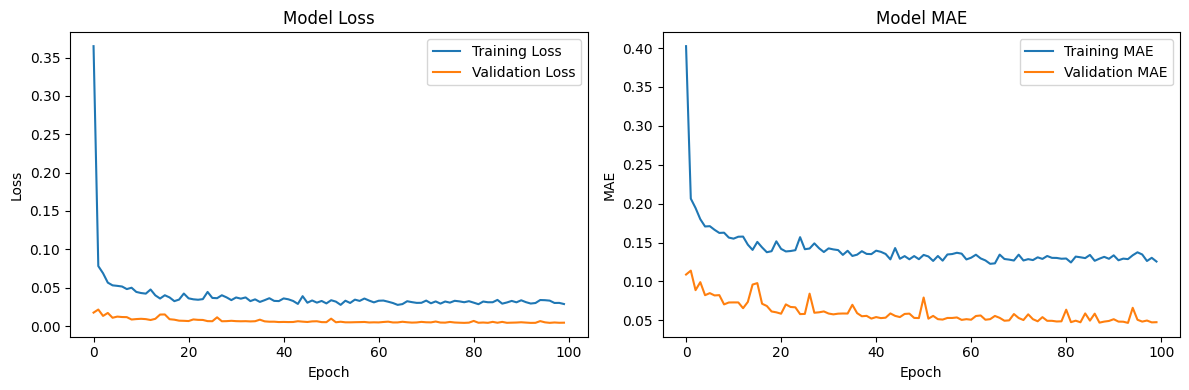

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Make predictions on test set
y_pred_test = model.predict(X_test)
print(y_pred_test.shape)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(299, 1)


In [14]:
print(y_pred_test)

[[-0.313362  ]
 [-0.35485393]
 [-0.3060328 ]
 [-0.25346193]
 [-0.28170145]
 [-0.27086538]
 [-0.29424924]
 [-0.3715528 ]
 [-0.42885524]
 [-0.46066198]
 [-0.5023893 ]
 [-0.53541046]
 [-0.5718775 ]
 [-0.57419395]
 [-0.42948106]
 [-0.3120873 ]
 [-0.3070787 ]
 [-0.10926247]
 [-0.14426863]
 [-0.1874272 ]
 [-0.19582999]
 [-0.18802112]
 [-0.15774977]
 [-0.20784591]
 [-0.25016594]
 [-0.28403556]
 [-0.32232043]
 [-0.30724913]
 [-0.25450003]
 [-0.26656497]
 [-0.26654592]
 [-0.24427828]
 [-0.2566803 ]
 [-0.17116106]
 [-0.19371302]
 [-0.25558278]
 [-0.23006481]
 [-0.23800105]
 [-0.24692972]
 [-0.22841385]
 [-0.22763504]
 [-0.24312863]
 [-0.26057374]
 [-0.26396555]
 [-0.24058884]
 [-0.23618375]
 [-0.26552412]
 [-0.30055612]
 [-0.2575009 ]
 [-0.19870754]
 [-0.21842232]
 [-0.15351163]
 [-0.15164515]
 [-0.18087825]
 [-0.17816736]
 [-0.17959192]
 [-0.14299536]
 [-0.06764984]
 [-0.03796196]
 [-0.02891797]
 [ 0.05562562]
 [ 0.24123824]
 [ 0.41084373]
 [ 0.48097098]
 [ 0.50059175]
 [ 0.5871268 ]
 [ 0.60241

In [15]:
# Inverse transform predictions and actual values for evaluation
y_pred_test_copies = np.repeat(y_pred_test, df_for_training.shape[1], axis=-1)
y_pred_test_inv = scaler.inverse_transform(y_pred_test_copies)[:, 0]

y_test_copies = np.repeat(y_test, df_for_training.shape[1], axis=-1)
y_test_inv = scaler.inverse_transform(y_test_copies)[:, 0]

In [16]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, y_pred_test_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_test_inv) / y_test_inv)) * 100

print("\n" + "="*50)
print("MODEL EVALUATION METRICS")
print("="*50)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("="*50)


MODEL EVALUATION METRICS
Mean Squared Error (MSE): 194.8207
Root Mean Squared Error (RMSE): 13.9578
Mean Absolute Error (MAE): 9.9230
R-squared (R²): 0.9689
Mean Absolute Percentage Error (MAPE): 3.54%


In [17]:
# NOW PREDICT FUTURE DATES (after the last date in dataset)
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Get the last date from our dataset
last_date = train_dates.iloc[-1]
print(f"\nLast date in dataset: {last_date}")


Last date in dataset: 2025-06-13 00:00:00


In [18]:
# Number of future days to predict
n_days_for_prediction = 30  # Predict next 30 business days

# Generate future business dates
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=n_days_for_prediction,
    freq=us_bd
).tolist()

print(f"Predicting from {future_dates[0]} to {future_dates[-1]}")

Predicting from 2025-06-16 00:00:00 to 2025-07-29 00:00:00


In [19]:
# For future predictions, we need to use the last n_past days as input
# and then predict step by step
last_sequence = df_for_training_scaled[-n_past:]
future_predictions = []

# Predict future values iteratively
current_sequence = last_sequence.copy()

for i in range(n_days_for_prediction):
    # Reshape for prediction
    current_input = current_sequence.reshape((1, n_past, df_for_training.shape[1]))

    # Make prediction
    next_pred = model.predict(current_input, verbose=0)
    future_predictions.append(next_pred[0, 0])

    # Update sequence for next prediction
    # Remove first element and add new prediction
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1] = next_pred[0]


In [20]:
# Convert predictions back to original scale
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_pred_copies = np.repeat(future_predictions, df_for_training.shape[1], axis=-1)
future_pred_inv = scaler.inverse_transform(future_pred_copies)[:, 0]

In [21]:
# Create future forecast dataframe
forecast_dates = [date.date() for date in future_dates]
df_future_forecast = pd.DataFrame({
    'Date': pd.to_datetime(forecast_dates),
    'Close': future_pred_inv
})

print(f"\nFuture Predictions (first 10 days):")
print(df_future_forecast.head(10))


Future Predictions (first 10 days):
        Date       Close
0 2025-06-16  321.552429
1 2025-06-17  318.520447
2 2025-06-18  315.883209
3 2025-06-20  313.371948
4 2025-06-23  310.992920
5 2025-06-24  308.748993
6 2025-06-25  306.663818
7 2025-06-26  304.708313
8 2025-06-27  302.835327
9 2025-06-30  301.002563


In [22]:
# Prepare original data for plotting
df_original = df.reset_index()
df_original['Date'] = pd.to_datetime(df_original['Date'])

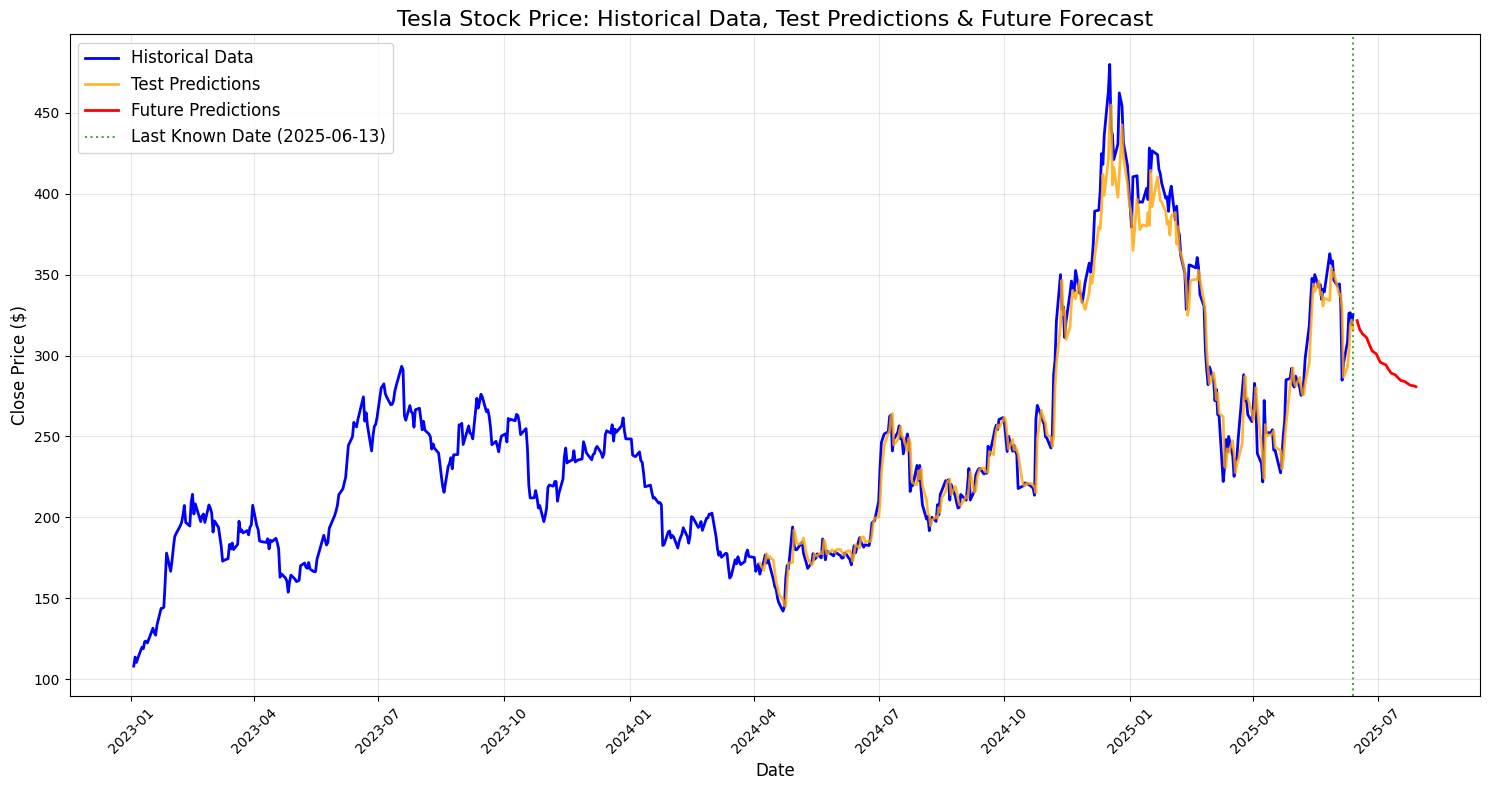

In [23]:
# Plot everything together
plt.figure(figsize=(15, 8))

# Plot original data (last 2 years for better visualization)
cutoff_date = pd.Timestamp('2023-01-01')
recent_data = df_original[df_original['Date'] >= cutoff_date]

plt.plot(recent_data['Date'], recent_data['Close'],
         label='Historical Data', color='blue', linewidth=2)

# Plot test predictions
test_start_idx = split_index + n_past
test_dates = train_dates.iloc[test_start_idx:test_start_idx + len(y_pred_test_inv)]
plt.plot(test_dates, y_pred_test_inv,
         label='Test Predictions', color='orange', linewidth=2, alpha=0.8)

# Plot future predictions
plt.plot(df_future_forecast['Date'], df_future_forecast['Close'],
         label='Future Predictions', color='red', linewidth=2)

plt.axvline(x=last_date, color='green', linestyle=':', alpha=0.7,
            label=f'Last Known Date ({last_date.strftime("%Y-%m-%d")})')

plt.title('Tesla Stock Price: Historical Data, Test Predictions & Future Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# Create a combined dataframe with all data
df_combined = pd.concat([
    df_original[['Date', 'Close']].assign(Type='Historical'),
    df_future_forecast[['Date', 'Close']].assign(Type='Future Prediction')
], ignore_index=True)

print(f"\nCombined dataset shape: {df_combined.shape}")
print(f"Historical data points: {len(df_original)}")
print(f"Future predictions: {len(df_future_forecast)}")


Combined dataset shape: (1538, 6)
Historical data points: 1508
Future predictions: 30


In [25]:
# Display summary statistics
print(f"\nSUMMARY STATISTICS")
# Corrected line: Access the scalar value using .iloc[-1].item()
print(f"Last known price: ${df_original['Close'].iloc[-1].item():.2f}")
# Corrected line: Access the scalar value using .iloc[-1].item()
print(f"Predicted price in 30 days: ${df_future_forecast['Close'].iloc[-1].item():.2f}")
# Corrected line: Access the scalar values using .item()
print(f"Predicted change: {((df_future_forecast['Close'].iloc[-1].item() / df_original['Close'].iloc[-1].item()) - 1) * 100:.2f}%")
# Corrected line: The mean of the series is already a scalar, so no .item() is needed here.
print(f"Average predicted price (next 30 days): ${df_future_forecast['Close'].mean():.2f}")

# Save predictions to CSV (optional)
df_future_forecast.to_csv('tesla_future_predictions.csv', index=False)
print(f"\nFuture predictions saved to 'tesla_future_predictions.csv'")

print(f"\nModel training completed successfully!")
print(f"Future predictions generated for {n_days_for_prediction} business days.")


SUMMARY STATISTICS
Last known price: $325.31
Predicted price in 30 days: $280.72
Predicted change: -13.71%
Average predicted price (next 30 days): $295.37

Future predictions saved to 'tesla_future_predictions.csv'

Model training completed successfully!
Future predictions generated for 30 business days.
